In [85]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import utils
import wandb
from torch.utils.data import DataLoader, Dataset
from itertools import combinations, product
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Subset

In [86]:
# shared_layer_sizes = [4096, 2048, 1024, 512]
embed_dim = 512
model_name = "contrastive_brain_retrieval_v4"
model_description = "increasing epochs to 250, single subject"
os.makedirs(f"../train_logs/{model_name}/", exist_ok=True)
# Hyperparameters
learning_rate = 1e-6
num_epochs = 250
batch_size = 32 # This is the number of matched pairs; the actual batch size will be double because of non-matched pairs.
hidden_dim=1024
seq_len=1
n_blocks=4

wandb.init(project='brain_contrastive_learning')
wandb.config.embed_dim = embed_dim
wandb.config.model_name = model_name
wandb.config.learning_rate = learning_rate
wandb.config.num_epochs = num_epochs
wandb.config.batch_size = batch_size
wandb.config.description = model_description


In [87]:
#Simple dataset class so I can make a dataloader
class NSDDataset(Dataset):
    def __init__(self, subject_data):
        self.data = subject_data

    def __len__(self):
        # Number of samples, not counting trials
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return all trials for the given sample
        return self.data[idx]
    
# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

# Model class
# class ContrastiveBrainActivityEncoder(nn.Module):
#     def __init__(self, shared_layer_sizes):
#         super(ContrastiveBrainActivityEncoder, self).__init__()
#         subject_input_dims = [15724, 14278, 15226, 13153, 13039, 17907, 12682, 14386]
#         self.subject_encoders = nn.ModuleDict({
#             f'subj0{i+1}': nn.Linear(in_features, shared_layer_sizes[0])
#             for i, in_features in enumerate(subject_input_dims)
#         })
        
#         # Shared layers
#         layers = []
#         for in_size, out_size in zip(shared_layer_sizes[:-1], shared_layer_sizes[1:]):
#             layers.append(nn.Linear(in_size, out_size))
#             layers.append(nn.ReLU(inplace=True))
#         self.shared_layers = nn.Sequential(*layers)

#     def forward(self, x, subj):
#         # Encode subject-specific input
#         x = self.subject_encoders[f'subj0{subj}'](x)
        
#         # Pass through shared layers
#         x = self.shared_layers(x)
        
#         return x
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
    
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=4, drop=.15, clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
            
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)

        return backbone

In [88]:
# Initialize the model

model = MindEyeModule()
model.ridge = RidgeRegression([15724, 14278, 15226, 13153, 13039, 17907, 12682, 14386], out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)
# test on subject 1 with fake data
b = torch.randn((2,seq_len,15724))
print(b.shape, model.ridge(b,0).shape)

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, n_blocks=n_blocks,
                          clip_size=embed_dim, out_dim=embed_dim)

utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)
backbone = model.backbone(b)
print(backbone.shape)

# model = ContrastiveBrainActivityEncoder(shared_layer_sizes)
device = torch.device('cuda:0')
model = model.to(device)

# Define the contrastive loss function
contrastive_loss_fn = nn.TripletMarginLoss(margin=1.0).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)


param counts:
119,196,672 total
119,196,672 trainable
param counts:
119,196,672 total
119,196,672 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 1024])
param counts:
8,929,816 total
8,929,816 trainable
param counts:
128,126,488 total
128,126,488 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 1, 512])


In [89]:
for subj in tqdm(range(1,2), desc='subjects'):
    train_voxels, _, _, _ = utils.load_nsd(subject=subj, average=False, nest=True)
    train_dataset = NSDDataset(train_voxels[:8000])
    val_dataset = NSDDataset(train_voxels[8000:])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    # Initialize early stopping object
    # early_stopping = EarlyStopping(patience=5, min_delta=0.001)
    for epoch in tqdm(range(num_epochs), desc='epochs)'):
        model.train()
        running_loss = 0.0
        for batch_idx, sample_trials in enumerate(train_dataloader):
            
            sample_trials = sample_trials.to(device)
            # sample_trials is of shape [batch_size, trials, voxels]
            batch_size, num_trials, _ = sample_trials.shape
            total_loss = 0  # Initialize total loss for the batch
            # Optimizer zero grad here is more efficient
            optimizer.zero_grad()
            embeddings = torch.zeros((batch_size, num_trials, embed_dim))
            for trial in range(num_trials):
                voxel_ridge = model.ridge(sample_trials[:, trial, :].unsqueeze(1),subj-1) # index of subj_list
                backbone = model.backbone(voxel_ridge)
                embeddings[:, trial, :] = backbone[:,0,:]
            
            # Get all possible pairs of trials (0, 1), (0, 2), (1, 2), etc.
            trial_pairs = list(combinations(range(num_trials), 2))

            # For each pair of trials, use one as anchor and the other as positive
            for anchor_trial, positive_trial in trial_pairs:
                anchor = embeddings[:, anchor_trial, :]
                positive = embeddings[:, positive_trial, :]
                
                # Compute distances to find hard negatives
                distances = torch.cdist(embeddings[:, anchor_trial, :], embeddings[:, positive_trial, :]).squeeze(0)
                distances.fill_diagonal_(float('inf'))
                _, negative_indices = distances.min(dim=1)W
                negative = embeddings[negative_indices, positive_trial, :]

                # Compute loss
                # anchor is batch_size * embedding_dim corresponding to the embedded vectors for an set of anchor patterns of brain activity
                # positive is batch_size * embedding_dim corresponding to the embedding vectors for a set of brain activity patterns that are for the same stimuli as the anchor, but a different repetition
                # negative is batch_size * embedding_dim corresponding to the embedding vectors for a set of brain activity patterns that are the closest in the batch to the anchor patterns, without being positive samples
                loss = contrastive_loss_fn(anchor, positive, negative)
                total_loss += loss  # Accumulate loss to update outside the loop

            total_loss.backward()  # Perform backpropagation once after accumulating losses
            optimizer.step()
            running_loss += total_loss.item()
        avg_train_loss = running_loss / len(train_dataloader)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_batch_idx, val_sample_trials in enumerate(val_dataloader):
                sample_trials = sample_trials.to(device)
                # sample_trials is of shape [batch_size, trials, voxels]
                batch_size, num_trials, _ = sample_trials.shape
                total_loss = 0  # Initialize total loss for the batch
                # Optimizer zero grad here is more efficient
                optimizer.zero_grad()
                embeddings = torch.zeros((batch_size, num_trials, embed_dim))
                for trial in range(num_trials):
                    voxel_ridge = model.ridge(sample_trials[:,trial].unsqueeze(1),subj-1) # index of subj_list
                    backbone = model.backbone(voxel_ridge)
                    embeddings[:, trial, :] = backbone[:,0,:]
                
                # Get all possible pairs of trials (0, 1), (0, 2), (1, 2), etc.
                trial_pairs = list(combinations(range(num_trials), 2))

                # For each pair of trials, use one as anchor and the other as positive
                for anchor_trial, positive_trial in trial_pairs:
                    anchor = embeddings[:, anchor_trial, :]
                    positive = embeddings[:, positive_trial, :]
                    
                    # Compute distances to find hard negatives
                    distances = torch.cdist(embeddings[:, anchor_trial, :], embeddings[:, positive_trial, :]).squeeze(0)
                    distances.fill_diagonal_(float('inf'))
                    _, negative_indices = distances.min(dim=1)
                    negative = embeddings[negative_indices, positive_trial, :]

                    # Compute loss
                    # anchor is batch_size * embedding_dim corresponding to the embedded vectors for an set of anchor patterns of brain activity
                    # positive is batch_size * embedding_dim corresponding to the embedding vectors for a set of brain activity patterns that are for the same stimuli as the anchor, but a different repetition
                    # negative is batch_size * embedding_dim corresponding to the embedding vectors for a set of brain activity patterns that are the closest in the batch to the anchor patterns, without being positive samples
                    loss = contrastive_loss_fn(anchor, positive, negative)
                    total_loss += loss  # Accumulate loss to update outside the loop
                val_running_loss += total_loss.item()
        avg_val_loss = val_running_loss / len(val_dataloader)
        wandb.log({"Training Loss": avg_train_loss, "Validation Loss": avg_val_loss})

        # # Early stopping
        # early_stopping(avg_val_loss)
        # if early_stopping.early_stop:
        #     print(f"Stopped early at epoch {epoch+1}")
        #     break  # Break out of the subject training loop to stop training

        # Save the model if this is the best validation loss so far
        # if avg_val_loss < early_stopping.best_loss:
        torch.save(model.state_dict(), f"../train_logs/{model_name}/last.pt")


print("Training complete.")
wandb.finish()


loading samples: 100%|██████████| 30000/30000 [00:06<00:00, 4692.34it/s]


Data Shapes... x_train: torch.Size([9000, 3, 15724]), x_test: torch.Size([1000, 3, 15724]), y_train: torch.Size([9000, 541875]), y_test: torch.Size([1000, 541875])


subjects: 100%|██████████| 1/1 [25:54<00:00, 1554.28s/it]


Training complete.


Training Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training Loss,0.00224
Validation Loss,0.0


In [90]:


def pairwise_distances(x, y=None):
    """
    Compute the 2D matrix of distances between all the embeddings.

    Args:
    x: tensor of shape (batch_size, embedding_size)
    y: tensor of shape (batch_size, embedding_size)

    Returns:
    distances: tensor of shape (batch_size, batch_size)
    """
    if y is None:
        y = x
    dists = torch.norm(x[:, None] - y, dim=2, p=2)
    return dists

# This function computes the model accuracy given a DataLoader
def compute_accuracy(subj, model, dataloader, device):
    model.eval()  # Set the model to inference mode
    correct_predictions = 0
    total_predictions = 0
    running_accuracy = 0

    with torch.no_grad():  # No gradients needed for inference
        # for batch_idx, sample_trials in enumerate(dataloader):
            # Move sample data to the GPU
        sample_trials = test_voxels.to(device)

        # Compute embeddings for all samples
        # print(sample_trials)
        # print(sample_trials.view(-1, sample_trials.size(-1)))
        embeddings = torch.zeros((sample_trials.shape[0], num_trials, embed_dim))
        for trial in range(num_trials):
            voxel_ridge = model.ridge(sample_trials[:,trial].unsqueeze(1),subj-1) # index of subj_list
            backbone = model.backbone(voxel_ridge)
            embeddings[:, trial, :] = backbone[:,0,:]
        # Calculate pairwise distances between all samples in the batch
        trial_pairs = list(combinations(range(3), 2))

        # For each pair of trials, use one as anchor and the other as positive
        for anchor_trial, positive_trial in trial_pairs:
            anchor_embeddings = embeddings[:, anchor_trial, :]
            positive_embeddings = embeddings[:, positive_trial, :]
            labels = torch.arange(len(anchor_embeddings)).to(anchor_embeddings.device) 
            running_accuracy += utils.topk(utils.batchwise_cosine_similarity(anchor_embeddings, positive_embeddings), labels, k=1).item()
        
    return running_accuracy/len(trial_pairs)

# Assuming the model and dataloader are already defined and the model is trained
device = torch.device('cuda:0')
model = model.to(device)

# Compute the accuracy
for subj in range(1,2):
    _, test_voxels, _, _ = utils.load_nsd(subject=subj, average=False, nest=True)
    test_dataset = NSDDataset(test_voxels)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model_accuracy = compute_accuracy(subj, model, test_dataloader, device)
    print(f"Model accuracy for subject {subj} in identifying matching trials: {model_accuracy * 100:.2f}%")


loading samples: 100%|██████████| 30000/30000 [00:06<00:00, 4714.99it/s]


Data Shapes... x_train: torch.Size([9000, 3, 15724]), x_test: torch.Size([1000, 3, 15724]), y_train: torch.Size([9000, 541875]), y_test: torch.Size([1000, 541875])
Model accuracy for subject 1 in identifying matching trials: 78.70%


In [95]:
from torchvision.transforms import ToPILImage
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image

def inference_and_display(model, subj, target_voxels, target_images, candidate_voxels, candidate_images, device):
    model.eval()
    with torch.no_grad():
        # Move tensors to the correct device
        target_voxels = target_voxels.to(device)
        candidate_voxels = candidate_voxels.to(device)
        
        # Process through the model's ridge section
        target_ridge = model.ridge(target_voxels, subj-1)
        candidate_ridge = model.ridge(candidate_voxels, subj-1)

        # Process the output of ridge through the model's backbone
        target_embeddings = model.backbone(target_ridge)
        candidate_embeddings = model.backbone(candidate_ridge)

        # Flatten the outputs if necessary (assuming the model outputs are not already vectors)
        if len(target_embeddings.shape) > 2:
            target_embeddings = target_embeddings.view(target_embeddings.size(0), -1)
        if len(candidate_embeddings.shape) > 2:
            candidate_embeddings = candidate_embeddings.view(candidate_embeddings.size(0), -1)

        # Calculate cosine similarities between target and all candidate embeddings
        similarities = F.cosine_similarity(target_embeddings.unsqueeze(1), candidate_embeddings.unsqueeze(0), dim=-1)
        
        # Find the index of the most similar candidate for each target
        max_indices = similarities.max(dim=1)[1]
        
        # Display the ground truth and retrieved images
        to_pil = ToPILImage()
        # Determine the number of rows (each row up to 6 pairs)
        num_samples = min(18, target_voxels.size(0))
        num_rows = (num_samples + 5) // 6  # Ensures we get enough rows

        # Display the ground truth and retrieved images
        for i in range(num_rows):
            fig, axs = plt.subplots(2, min(6, num_samples - i * 6), figsize=(15, 4))
            for j in range(min(6, num_samples - i * 6)):
                index = i * 6 + j

                # Ground Truth Image
                ax = axs[0, j] if num_samples > 6 else axs[j]
                ax.imshow(to_pil(target_images[index].cpu()))
                # ax.imshow(Image.fromarray(target_images[index].cpu().numpy().reshape((425, 425, 3)).astype(np.uint8)))
                ax.set_title("Ground Truth")
                ax.axis('off')

                # Retrieved Image
                ax = axs[1, j] if num_samples > 6 else axs[j]
                # ax.imshow(to_pil(candidate_images[max_indices[index]].cpu()))
                ax.imshow(Image.fromarray(candidate_images[max_indices[index]].cpu().numpy().reshape((425, 425, 3)).astype(np.uint8)))
                ax.set_title("Retrieved")
                ax.axis('off')

            plt.show()

In [97]:
train_voxels, _, train_stim, _ = utils.load_nsd(subject=1, average=False, nest=False)

_, test_voxels, _, test_stim = utils.load_nsd(subject=1, average=True, nest=False)

im_voxels, im_stimulus = utils.load_nsd_mental_imagery(subject=1, mode="vision", stimtype="all", average=True, nest=False)


loading samples: 100%|██████████| 30000/30000 [00:14<00:00, 11888.70it/s]

Data Shapes... x_train: torch.Size([27000, 15724]), x_test: torch.Size([3000, 15724]), y_train: torch.Size([27000, 541875]), y_test: torch.Size([3000, 541875])


loading samples: 100%|██████████| 30000/30000 [00:07<00:00, 4281.37it/s]


Data Shapes... x_train: torch.Size([9000, 15724]), x_test: torch.Size([1000, 15724]), y_train: torch.Size([9000, 541875]), y_test: torch.Size([1000, 541875])
torch.Size([18, 1, 15724]) torch.Size([18, 3, 425, 425])


torch.Size([1000, 15724]) torch.Size([27000, 541875]) torch.Size([18, 3, 425, 425])


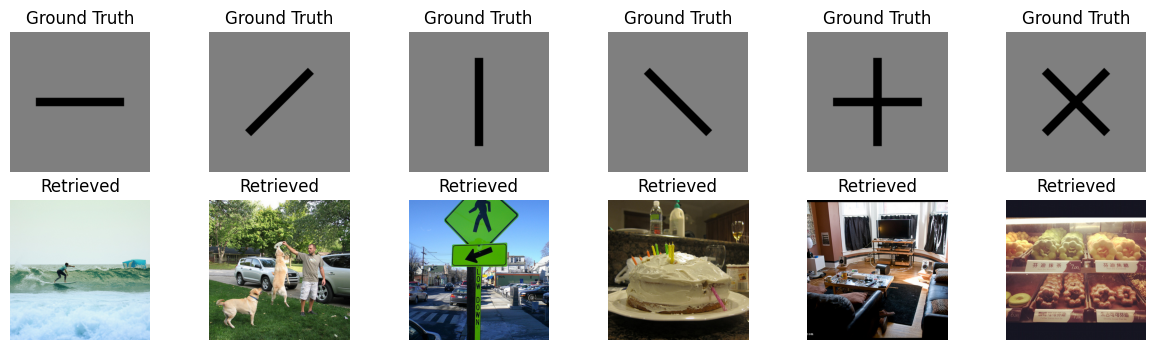

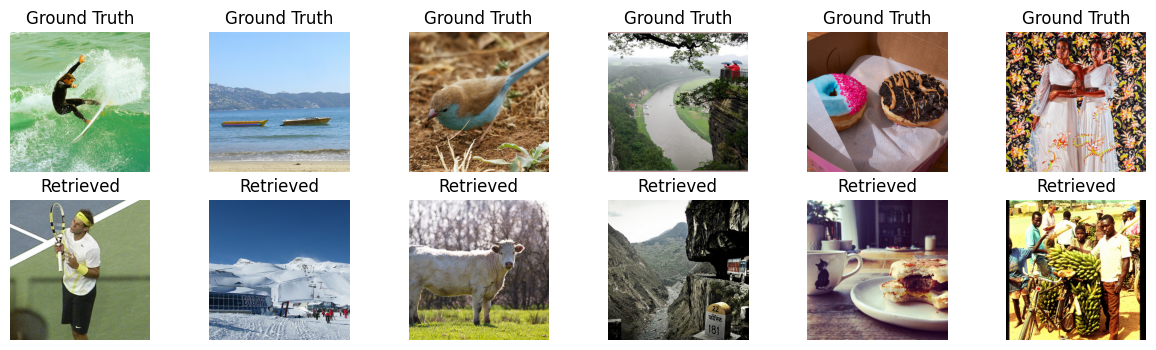

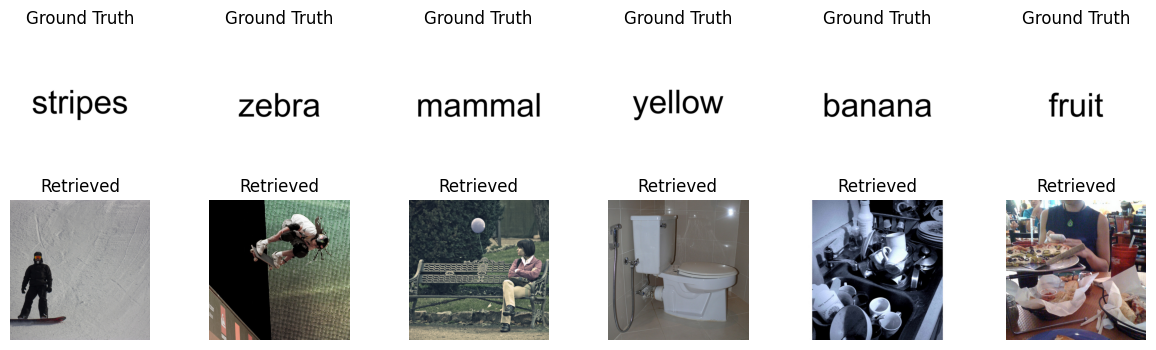

In [98]:
print(test_voxels.shape, train_stim.shape, im_stimulus.shape)
# inference_and_display(model, 1, test_voxels[:18].unsqueeze(1), test_stim[:18], train_voxels.unsqueeze(1), train_stim, device)
inference_and_display(model, 1, im_voxels, im_stimulus, train_voxels.unsqueeze(1), train_stim, device)